# **Reinforcement Learning**
<img align="right" src="https://vitalflux.com/wp-content/uploads/2020/12/Reinforcement-learning-real-world-example.png">

- In reinforcement learning, your system learns how to interact intuitively with the environment by basically doing stuff and watching what happens.

if you need the last version of gym use block of code below:
```
!pip uninstall gym -y
!pip install gym
```

In [ ]:
# !pip install -U gym==0.25.2
!pip install gym[atari]
!pip install autorom[accept-rom-license]
!pip install swig
!pip install gym[box2d]

In [97]:
import random
import math
from collections import defaultdict
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import gym
from IPython.core.display import HTML
from base64 import b64encode
from gym.wrappers import record_video, record_episode_statistics
from gym.wrappers import RecordVideo, RecordEpisodeStatistics

import torch
from torch.autograd import Variable

import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

import warnings
warnings.filterwarnings('ignore')

In [3]:
def display_video(episode=0, video_width=600, video_dir= "/content/video"):
    video_path = os.path.join(video_dir, f"rl-video-episode-{episode}.mp4")
    video_file = open(video_path, "rb").read()
    decoded = b64encode(video_file).decode()
    video_url = f"data:video/mp4;base64,{decoded}"
    return HTML(f"""<video width="{video_width}"" controls><source src="{video_url}"></video>""")

def create_env(name, render_mode=None, video_folder='/content/video'):
    # render mode: "human", "rgb_array", "ansi")
    env = gym.make(name, new_step_api=True, render_mode=render_mode)
    env = RecordVideo(env, video_folder=video_folder, episode_trigger=lambda x: x % 50 == 0)
    env = RecordEpisodeStatistics(env)
    return env

def show_reward(total_rewards):
    plt.plot(total_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.show()

The **TD** method is able to update the Q-function on the fly during an episode, which is considered an advancement on the **MC** method. However, the TD method is still not sufficiently scalable for problems with many states and/or actions. It will be extremely slow at learning too many values for individual pairs of states and actions using the TD method.

Methods we have seen so far work well when we have a tabular representation for each state, that is, when we represent value function with a lookup table., This is not reasonable on most cases:
- In Large state spaces: There are too many states and/or actions to store in memory (f.i. Backgammon: 1020 states, Go 10170 states)
- In continuous state spaces (f.i. robotic examples)

We will focus on **function approximation**, which can overcome the scaling issues in the TD method.
1. developing the linear function estimator.
2. incorporate it into the Q-learning and SARSA algorithms.
3. improve the Q-learning algorithm using experience replay.
4. experiment with using neural works as a function estimator

<br>

- **What Is Function Approximation**

Function approximation is a technique for estimating an unknown underlying function using historical or available observations from the domain.

- Function approximation is often related to a Markov decision process (MDP) which consists of an agent and various states.

- Artificial neural networks learn to approximate a function.

## **Estimating Q-functions with gradient descent approximation**

we will develop FA algorithms to solve environments with continuous state variables. We will begin by approximating Q-functions using linear functions and gradient descent.

The main idea of FA is to use a set of features to estimate Q values. This is extremely useful for processes with a large state space where the Q table becomes huge. There are several ways to map the features to the Q values; for example, linear approximations that are linear combinations of features and neural networks. With linear approximation, the state-value function for an action is expressed by a weighted sum of the features:

<br>

$$
\large V(a) = \theta_1F_1(s) + \theta_2F_2(s) + ... + \theta_nF_n(s)
$$

<br>

Here, $F_1(s), F_2(s), ……, F_n(s) $ is a set of features given the input state, $s; θ_1, θ_2,..., θ_n$ are the weights applied to corresponding features. Or we can put it as $V(s)=θF(s)$.

As we have seen this in the TD method, we have the following formula to compute the future states:

<br>

$$
\large V(s_t) := V(s_t) + \alpha[r + \gamma V(s_{t+1}) - V(s_t)]
$$

<br>

$$
\large \delta = r + \gamma V_(s_{t+1}) - V(s_t)
$$

<br>

$$
\large V(s_t) = V(s_t) + \alpha \delta
$$
<br>

This is in the exact form of gradient descent. Hence:
- the goal of learning is to find the optimal weights, $θ$, to best approximate the state-value function for each possible action.
- The loss function we are trying to minimize in this case is similar to that in a regression problem, which is the **mean squared error** between the actual value and the estimated value.

After each step in an episode, we have a new estimation of the true state value, and we move the weights, $θ$, a step toward their optimal value.


**Note**: One more thing to note is the feature set, $F(s)$, given the input state, s. A good feature set is one that can capture the dynamics of different inputs. Typically, we can generate a set of features with a set of **Gaussian functions** under various parameters, including mean and standard deviation.

### **Estimator**
1. Initialize constructor:
    - Inpute: It takes in three parameters, the number of features, n_feat; the number of states; and the number of actions.

    - first generates a set of coefficients, w and b, for the feature function F(s) from Gaussian distributions, which we will define in the class.

    -  then initializes n_action linear models, where each model corresponds to an action, and n_action optimizers, accordingly.

    - For the linear model, we use the Linear module from PyTorch. It takes in n_feat units and generates one output, which is the predicted state-value for an action.

2. Next, we develop the function to map the state space to the feature space based on w and b:
    - The feature of a state, s, is generated as follows:
    - Use cosine transformation to ensure that the feature is in the range of [-1, 1] despite the value of an input state.

$$
F(s) = \sqrt{\frac{2}{\small \textit{number of feature}}} * cos(ws + b)
$$

3. Since we've defined model and feature generation, we now develop the training method, which updates the linear models with a data point:
    - Inpute: state, action, target value
    - First converts the state to feature space with the `_get_feature` method.
    - The resulting features are then fed into the current linear model of the given action, a.
    - The predictive result, along with the target value, is used to compute the loss and gradients.
    - The weights, θ, are then updated via backpropagation.

4. The next operation involves predicting the state-value for each action given a state using the current models:


In [55]:
class Estimator():

    def __init__(self, n_feat, n_state, n_action, lr=0.05):
        self.n_state = n_state
        self.n_action = n_action
        self.n_feat = n_feat
        self.lr = lr

        self.w, self.b = self._gaussian_function()
        self.models = []
        self.optimizers = []
        self.criterion = torch.nn.MSELoss()
        for _ in range(self.n_action):
            model = torch.nn.Linear(self.n_feat, 1)
            optimizer = torch.optim.SGD(model.parameters(), self.lr)
            self.models.append(model)
            self.optimizers.append(optimizer)

    def _gaussian_function(self, sigma=.2):
        torch.manual_seed(7)
        w = torch.randn((self.n_state, self.n_feat)) * (1 / sigma)
        b = torch.rand(self.n_feat) * 2 * math.pi
        return w, b

    def _get_feature(self, s):
        arc = torch.matmul(torch.tensor(s).float(), self.w ) + self.b
        return (2 / self.n_feat) ** .5 * torch.cos(arc)

    def update(self, s, a, y):
        features = Variable(self._get_feature(s))
        y_pred = self.models[a](features)
        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))

        self.optimizers[a].zero_grad()
        loss.backward()
        self.optimizers[a].step()


    def predict(self, s):
        features = self._get_feature(s)
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])



In [56]:
# Check the Estimator
estimator = Estimator(10, 2, 1)
s1 = [0.5, 0.1]
estimator._get_feature(s1)

tensor([ 0.4198, -0.4458, -0.4072, -0.1476, -0.0998, -0.4301, -0.3951, -0.3647,
        -0.4303,  0.4295])

In [61]:
# Train the estimator on a list of states and target state-values
s_list = [[1, 2], [2, 2], [3, 4], [2, 3], [2, 1]]
target_list = [1, 1.5, 2, 2, 1.5]
estimator = Estimator(10, 2, 1)
for s, target in zip(s_list, target_list):
    feature = estimator._get_feature(s)
    estimator.update(s, 0, target)

print(estimator.predict([0.5, 0.1]))
print('----------')
print(estimator.predict([2, 3]))

tensor([0.5808])
----------
tensor([0.9981])


## **Mountain Car Environment**

<img width="400" align="right" src="https://www.gymlibrary.dev/_images/mountain_car.gif">


<br>

<table>
<tr>
    <td><font size="3">Action Space</td>
    <td><font size="3">Discrete(3)</td>
</tr>
<tr>
    <td><font size="3">Observation Shape</td>
    <td><font size="3">(2,))</td>
</tr>
<tr>
    <td><font size="3">Observation High</td>
    <td><font size="3">[0.6,  0.07]</td>
</tr>
<tr>
    <td><font size="3">Observation Low</td>
    <td><font size="3">[-1.2,  0.07]</td>
<tr>
<tr>
    <td><font size="3">Import</td>
    <td><font size="4"><code>gym.make("MountainCar-v0")</code></td>
<tr>

In [62]:
env = create_env("MountainCar-v0")

## **Developing Q-learning with linear function approximation**

As we have seen, Q-learning is an off-policy learning algorithm and it updates the Qfunction based on the following equation:

<br>

$$
\\ \large Q(s, a) ← Q(s, a) + \alpha[r + \gamma max_{a'} Q(s', a') - Q(s, a)]
$$

<br>

$
 \textit{ s' is the resulting state after taking action a, in state, s;} \\
 \textit{ r is the associated reward;} \\
 \textit{ α is the learning rate; and γ is the discount factor}
$

<br>

 Also, $max_{a'} Q(s', a')$, means that the behavior policy is greedy, where the highest Q-value among those in state s' is selected to generate learning data. In Q-learning, actions are taken on the basis of the epsilon-greedy policy. Similarly, Q-learning with FA has the following error term:

 <br>

$$
\large \delta = r + \gamma V_(s_{t+1}) - V(s_t) = r + \gamma max_{a'} V(s') - V(s_t)
$$

<br>

Our learning goal is to minimize the error term to zero, which means the estimated V(st) should satisfy the following equation:

 <br>

$$
\large V(s_t) = r + \gamma max_{a'} V(s')
$$

<br>

Now, the goal becomes finding the optimal weights, $θ$, as in $V(s)=θF(s)$, to best approximate the state-value function $V(s)$ for each possible action.

<br>

The `q_learning()` function does the following tasks:

- In each episode, creates an epsilon-greedy policy with an epsilon factor decayed to 99% (for example, if epsilon in the first episode is 0.1, it will be 0.099 in the second episode).

- Runs an episode: in each step, takes an action, a, in keeping with the epsilon greedy policy; computes the Q values of the new state using the current estimator; then, computes the target value, , and uses it to train the estimator.

- Runs n_episode episodes and records the total reward for each episode.

In [65]:
def gen_epsilon_greedy(estimator, n_action, epsilon):
    def policy(state):
        prob = torch.ones(n_action) * (epsilon / n_action)
        q_values = estimator.predict(state)
        best_action = torch.argmax(q_values).item()
        prob[best_action] += 1 - epsilon
        action = torch.multinomial(prob, 1).item()
        return action
    return policy

In [78]:
def q_learning(env, estimator, n_episode, epsilon, epsilon_decay=.99, gamma=1.):
    n_action = env.action_space.n
    global length_episode
    global total_reward_episode
    length_episode = [0] * n_episode
    total_reward_episode = [0] * n_episode

    for episode in range(n_episode):
        if episode % 50 == 0 and episode > 0:
            print(f"-- Episode: {episode} is running")
        epsilon_greedy = gen_epsilon_greedy(estimator, n_action, epsilon * epsilon_decay ** episode,)
        state = env.reset()
        done = False
        while not done:
            action = epsilon_greedy(state)
            next_state, reward, done, _ = env.step(action)
            # Q learning
            q_values_next = estimator.predict(next_state)
            td_target = reward + gamma * torch.max(q_values_next)
            estimator.update(state, action, td_target)
            state = next_state

            length_episode[episode] += 1
            total_reward_episode[episode]+= reward


In [79]:
env = create_env("MountainCar-v0")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
lr = 0.03
estimator = Estimator(n_feature, n_state, n_action, lr)

n_episode = 300
q_learning(env, estimator, n_episode, epsilon=0.1)

-- Episode: 50 is running
-- Episode: 100 is running
-- Episode: 150 is running
-- Episode: 200 is running
-- Episode: 250 is running


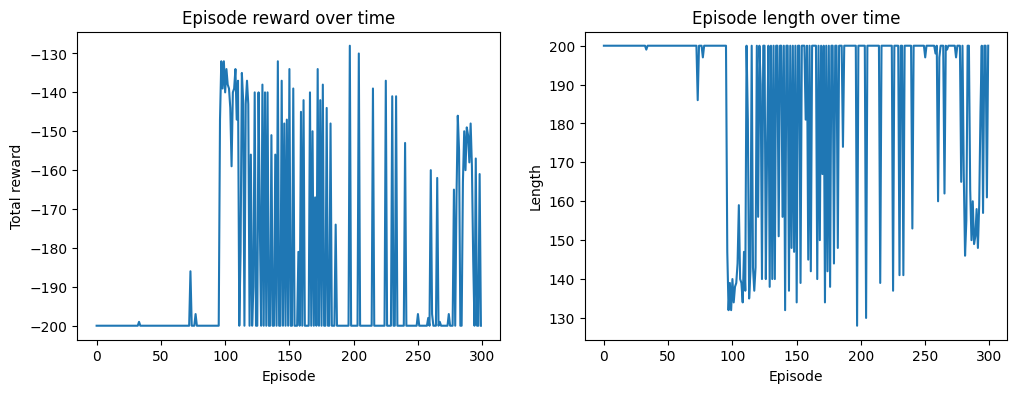

In [80]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

In [83]:
display_video(250)

## **Developing SARSA with linear function approximation**

In general, the SARSA algorithm updates the Q-function based on the following equation:

<br>

$$
\\ \large Q(s, a) ← Q(s, a) + \alpha[r + \gamma Q(s', a') - Q(s, a)]
$$

<br>

$
 \textit{ s' is the resulting state after taking action a, in state, s;} \\
 \textit{ r is the associated reward;} \\
 \textit{ α is the learning rate; and γ is the discount factor;} \\
 \textit{ a' is the next action by epsilon-greedy policy}
$

 <br>

SARSA with FA has the following error term:

<br>

$$
\large \delta = r + \gamma V_(s_{t+1}) - V(s_t) = r + \gamma V(s', a') - V(s_t)
$$

<br>

Our learning goal is to minimize the error term to zero, which means that the estimated V(s_t) should satisfy the following equation:

 <br>

$$
\large V(s_t) = r + \gamma V(s', a')
$$

In [84]:
def SARSA(env, estimator, n_episode, epsilon, epsilon_decay=.99, gamma=1.):
    n_action = env.action_space.n
    global length_episode
    global total_reward_episode
    length_episode = [0] * n_episode
    total_reward_episode = [0] * n_episode

    for episode in range(n_episode):
        if episode % 50 == 0 and episode > 0:
            print(f"-- Episode: {episode} is running")
        epsilon_greedy = gen_epsilon_greedy(estimator, n_action, epsilon * epsilon_decay ** episode,)
        state = env.reset()
        action = epsilon_greedy(state)
        done = False
        while not done:
            next_state, reward, done, _ = env.step(action)
            # Q learning
            q_values_next = estimator.predict(next_state)
            next_action = epsilon_greedy(next_state)
            td_target = reward + gamma * q_values_next[next_action]
            estimator.update(state, action, td_target)
            state = next_state
            action = next_action

            length_episode[episode] += 1
            total_reward_episode[episode]+= reward


In [85]:
env = create_env("MountainCar-v0")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
lr = 0.03
estimator = Estimator(n_feature, n_state, n_action, lr)

n_episode = 300
SARSA(env, estimator, n_episode, epsilon=0.1)

-- Episode: 50 is running
-- Episode: 100 is running
-- Episode: 150 is running
-- Episode: 200 is running
-- Episode: 250 is running


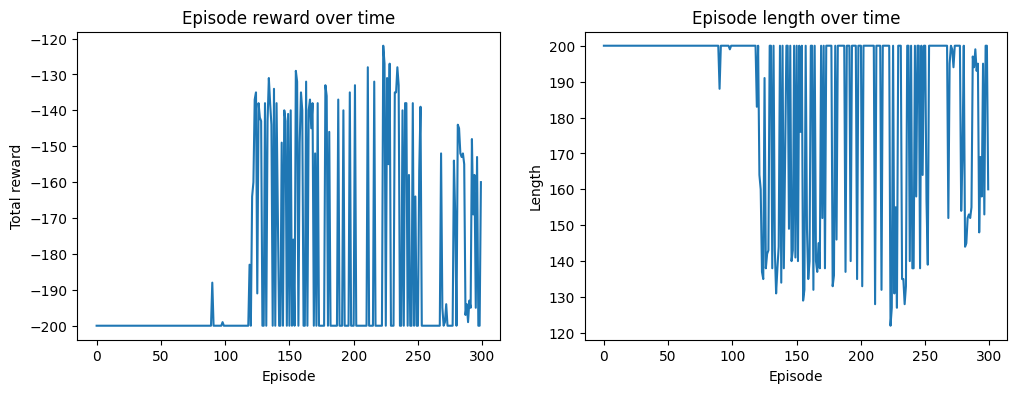

In [86]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

In [90]:
display_video(150)

## **Incorporating batching using experience replay**

we will improve the performance of off-policy Qlearning by incorporating experience replay. also called the **buffer**, or **memory**

**Experience replay** means we store the agent's experiences during an episode instead of running Q-learning.
The learning phase with experience replay becomes two phases:
1. gaining experience
2. updating models based on the experience obtained after an episode finishes.

the experience includes the past state, the action taken, the reward received, and the next state for individual steps in an episode.

In [109]:
from collections import deque

def q_learning_buffer(env, estimator, n_episode, replay_size, epsilon=.1, epsilon_decay=.99, gamma=1., buffer_size=300):
    n_action = env.action_space.n
    global length_episode
    global total_reward_episode
    length_episode = [0] * n_episode
    total_reward_episode = [0] * n_episode
    memory = deque(maxlen=buffer_size)

    for episode in range(n_episode):
        if episode % 50 == 0 and episode > 0:
            print(f"-- Episode: {episode} is running")
        epsilon_greedy = gen_epsilon_greedy(estimator, n_action, epsilon * epsilon_decay ** episode,)
        state = env.reset()
        done = False
        while not done:
            action = epsilon_greedy(state)
            next_state, reward, done, _ = env.step(action)
            length_episode[episode] += 1
            total_reward_episode[episode] += reward

            if done:
                break
            # Q learning
            q_values_next = estimator.predict(next_state)
            td_target = reward + gamma * torch.max(q_values_next)
            memory.append((state, action, td_target))
            state = next_state

        replay_data = random.sample(memory, min(replay_size, len(memory)))
        for state, action, td_target in replay_data:
            estimator.update(state, action, td_target)


In [115]:
env = create_env("MountainCar-v0")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
replay_size = 200
lr = 0.1
estimator = Estimator(n_feature, n_state, n_action, lr)

n_episode = 300
q_learning_buffer(env, estimator, n_episode, replay_size, epsilon=0.1)

-- Episode: 50 is running
-- Episode: 100 is running
-- Episode: 150 is running
-- Episode: 200 is running
-- Episode: 250 is running


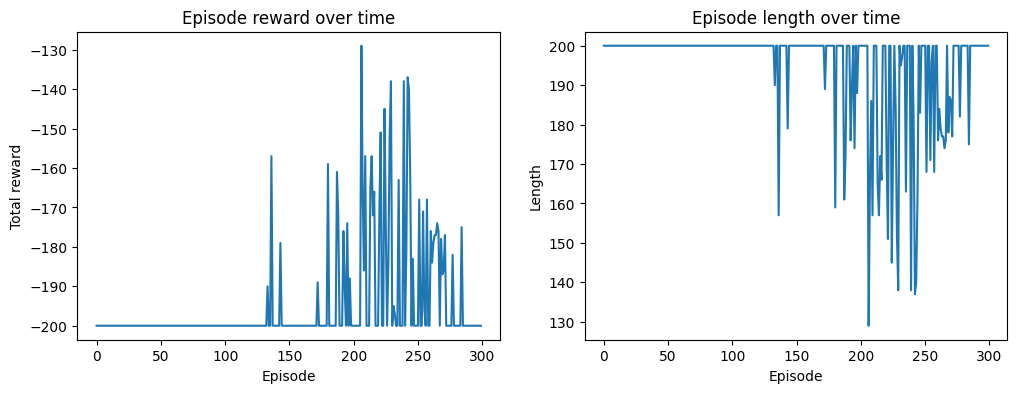

In [116]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

In [117]:
display_video(200)

## **Developing Q-learning with neural network function approximation**

In [121]:
class EstimatorNN():

    def __init__(self, n_feat, n_hidden, n_state, n_action, lr=0.05):
        self.n_state = n_state
        self.n_hidden = n_hidden
        self.n_action = n_action
        self.n_feat = n_feat
        self.lr = lr

        self.w, self.b = self._gaussian_function()
        self.models = []
        self.optimizers = []
        self.criterion = torch.nn.MSELoss()
        for _ in range(self.n_action):
            model = torch.nn.Sequential(
                torch.nn.Linear(self.n_feat, self.n_hidden),
                torch.nn.ReLU(),
                torch.nn.Linear(self.n_hidden, 1)
            )
            optimizer = torch.optim.Adam(model.parameters(), self.lr)
            self.models.append(model)
            self.optimizers.append(optimizer)

    def _gaussian_function(self, sigma=.2):
        torch.manual_seed(7)
        w = torch.randn((self.n_state, self.n_feat)) * (1 / sigma)
        b = torch.rand(self.n_feat) * 2 * math.pi
        return w, b

    def _get_feature(self, s):
        arc = torch.matmul(torch.tensor(s).float(), self.w ) + self.b
        return (2 / self.n_feat) ** .5 * torch.cos(arc)

    def update(self, s, a, y):
        features = Variable(self._get_feature(s))
        y_pred = self.models[a](features)
        loss = self.criterion(y_pred, Variable(torch.Tensor([y])))

        self.optimizers[a].zero_grad()
        loss.backward()
        self.optimizers[a].step()


    def predict(self, s):
        features = self._get_feature(s)
        with torch.no_grad():
            return torch.tensor([model(features) for model in self.models])



In [122]:
env = create_env("MountainCar-v0")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 200
n_hidden = 50
replay_size = 128
lr = 0.01
estimator = EstimatorNN(n_feature, n_hidden, n_state, n_action, lr)

n_episode = 300
q_learning_buffer(env, estimator, n_episode, replay_size, epsilon=0.1)

-- Episode: 50 is running
-- Episode: 100 is running
-- Episode: 150 is running
-- Episode: 200 is running
-- Episode: 250 is running


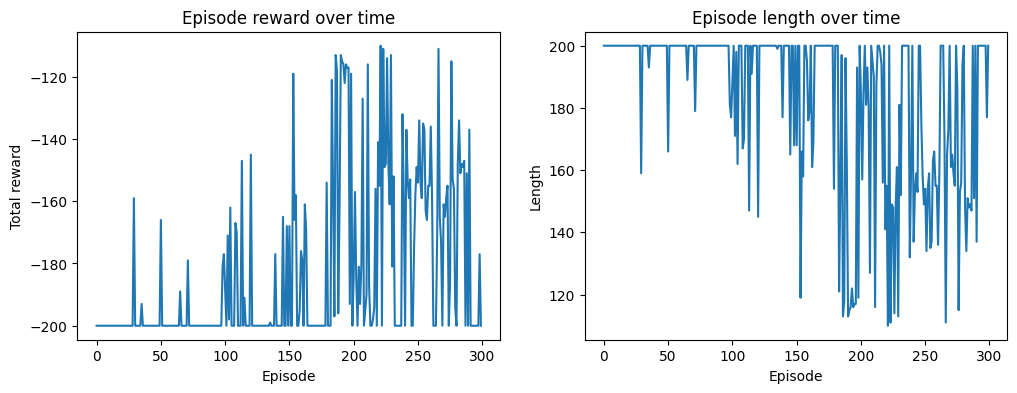

In [123]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

In [125]:
display_video(250)

## **Cart Pole environment**

<img width="400" align="right" src="https://www.gymlibrary.dev/_images/cart_pole.gif">


<br>

<table>
<tr>
    <td><font size="3">Action Space</td>
    <td><font size="3">Discrete(2)</td>
</tr>
<tr>
    <td><font size="3">Observation Shape</td>
    <td><font size="3">(4,))</td>
</tr>
<tr>
    <td><font size="3">Observation High</td>
    <td><font size="3">[4.8 inf 0.42 inf]</td>
</tr>
<tr>
    <td><font size="3">Observation Low</td>
    <td><font size="3">[-4.8 -inf -0.42 -inf]</td>
<tr>
<tr>
    <td><font size="3">Import</td>
    <td><font size="4"><code>gym.make("CartPole-v1")</code></td>
<tr>



In [147]:
env = create_env("CartPole-v1")
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_feature = 512
n_hidden = 256
replay_size = 256
lr = 0.01
estimator = EstimatorNN(n_feature, n_hidden, n_state, n_action, lr)

n_episode = 500
q_learning_buffer(env, estimator, n_episode, replay_size, epsilon=0.1, buffer_size=512)

-- Episode: 50 is running
-- Episode: 100 is running
-- Episode: 150 is running
-- Episode: 200 is running
-- Episode: 250 is running
-- Episode: 300 is running
-- Episode: 350 is running
-- Episode: 400 is running
-- Episode: 450 is running


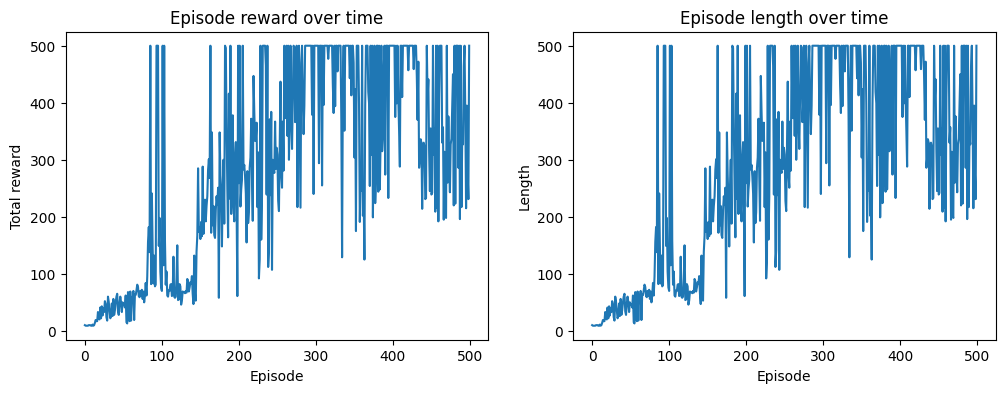

In [148]:
fig = plt.figure(figsize=(12, 4))
fig.add_subplot(1, 2, 1)
plt.plot(total_reward_episode)
plt.title('Episode reward over time')
plt.xlabel('Episode')
plt.ylabel('Total reward')

fig.add_subplot(1, 2, 2)
plt.plot(length_episode)
plt.title('Episode length over time')
plt.xlabel('Episode')
plt.ylabel('Length')

plt.show()

In [149]:
display_video(450)